## Import Libraries
The code used to implement the TD3 agent is taken from here: https://github.com/higgsfield/RL-Adventure-2.

In [1]:
import math
import random
import time
import pandas as pd

from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

False

## Plot Functions

In [2]:
plt.rcParams.update({'font.size': 18})
def plot_rewards(rewards):
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    plt.close()

def plot_smoothed(rewards, a):
    rewards_ema = pd.DataFrame(rewards).ewm(alpha = a).mean()
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(rewards_ema)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards (EMA)")
    plt.show()
    plt.close()


## Save gifs of agent

In [3]:
def save_frames_as_gif(frames, path='./Visualizations/', filename='pendulum_gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='pillow', fps= 120)

## Create log(cosh) loss

In [4]:
def log_cosh(x):
    return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)

def log_cosh_loss(y_pred, y_true):
    return torch.mean(log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        return log_cosh_loss(y_pred, y_true)

## Replay Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        # Add space in buffer to add next tuple
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # Add tuple to buffer
        self.buffer[self.position] = (state, action, reward, next_state, done)
        # Cycle index to beginning once buffer is full
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Creates a tuple of 5 elements: states, actions, ...., dones
        # Each element is an array of length = batch_size
        # i.e. first element is an array of states, second is an array of actions, etc
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

## Normalize action space

In [6]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return action

## Gaussian Noise

In [7]:
class GaussianExploration(object):
    def __init__(self, action_space, max_sigma=1.0, min_sigma=1.0, decay_period=1000000):
        self.low  = action_space.low
        self.high = action_space.high
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
    
    def get_action(self, action, t=0):
        sigma  = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        action = action + np.random.normal(scale = 0.1, size=len(action)) * sigma
        # Output: array([action])
        return np.clip(action, self.low, self.high)

## Soft Update Function for Targets

In [8]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

## Define Actor and Critic Networks

In [9]:
# Critic
class ValueNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        self.hidden_size2 = 300
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, self.hidden_size2)
        self.linear3 = nn.Linear(self.hidden_size2, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
# Actor
class PolicyNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        self.hidden_size2 = 300
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, self.hidden_size2)
        self.linear3 = nn.Linear(self.hidden_size2, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        # [0] extracts [action] from array([[action]])
        return action.detach().cpu().numpy()[0]

## TD3 Update

In [10]:
def td3_update(step,
           batch_size,
           replay_buffer,
           gamma = 0.99,
           soft_tau=5 * 1e-3,
           noise_std = 0.1,
           noise_clip=0.5,
           policy_update=2,
          ):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    # Converts to tensor and adds extra dimension
    # i.e. tensor([[r_1], [r_2], ..., [r_n]])
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    # Converts dones to floats and does same conversion as rewards
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    # Select next action and add noise
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(device)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise

    # Calculate expected Q from target
    target_q_value1  = target_value_net1(next_state, next_action)
    target_q_value2  = target_value_net2(next_state, next_action)
    target_q_value   = torch.min(target_q_value1, target_q_value2)
    expected_q_value = reward + (1.0 - done) * gamma * target_q_value

    # Optimize critics
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())

    value_optimizer1.zero_grad()
    value_loss1.backward()
    value_optimizer1.step()

    value_optimizer2.zero_grad()
    value_loss2.backward()
    value_optimizer2.step()

    # Update target and optimize policy every policy_update steps
    if step % policy_update == 0:
        policy_loss = value_net1(state, policy_net(state))
        policy_loss = -policy_loss.mean()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=soft_tau)
        soft_update(value_net2, target_value_net2, soft_tau=soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=soft_tau)

## Initialize Objects and Values

In [11]:
num_eps = 450
np.random.seed(24)
random.seed(24)
max_steps = 1000
batch_size  = 128

# env = NormalizedActions(gym.make("BipedalWalker-v3"))
env = gym.make("BipedalWalker-v3")
env.reset(seed = 24)
# Initialize noise with action space information
noise = GaussianExploration(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 400

seed1 = 24
seed2 = 8
seed3 = 17

value_net1 = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
value_net2 = ValueNetwork(seed2, state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)

target_value_net1 = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
target_value_net2 = ValueNetwork(seed2, state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = LogCoshLoss()

policy_lr = 1e-3
value_lr  = 1e-3

value_optimizer1 = optim.Adam(value_net1.parameters(), lr=value_lr)
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

## Task 1 (training)
Note: same replay buffer for all task during training

Episode:  0
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Training Complete


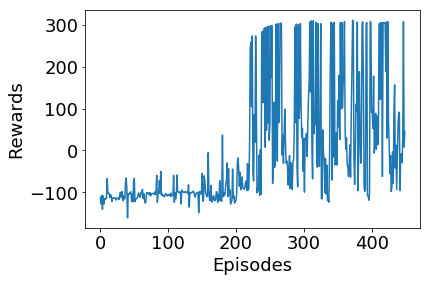

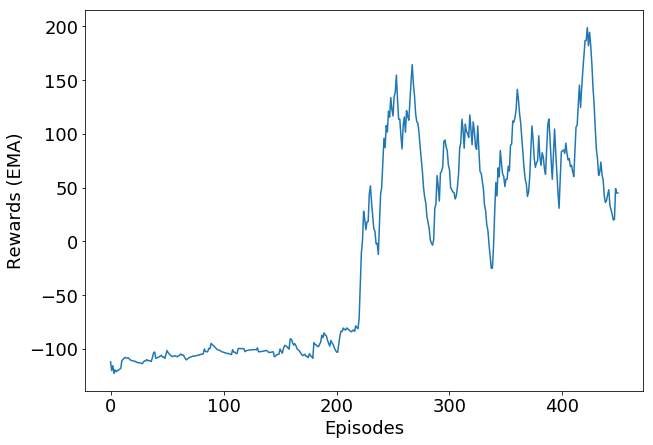

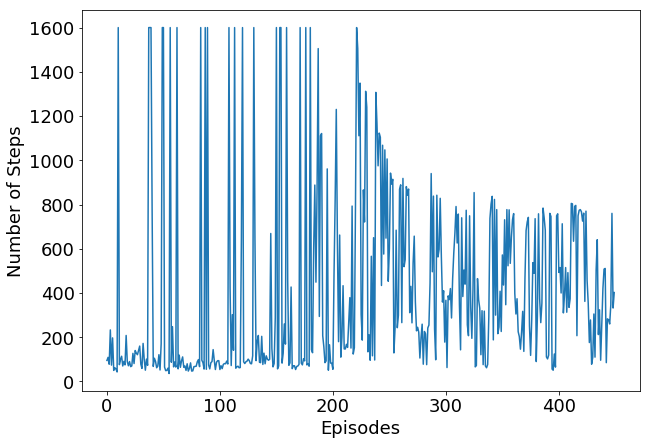

In [12]:
rewards_train = {}
rewards_test = {}
rewards_train['task1'] = []
eps = []

replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = env.reset()
    ep_reward = 0
    t = 0
    done = False
#     for t in range(max_steps):
    while not done:
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer)
        
        state = next_state
        ep_reward += reward
        t += 1
        
        if done:
            break
    eps.append(t)

    rewards_train['task1'].append(ep_reward)

print('Training Complete')
rewards_env1 = rewards_train['task1']
plot_rewards(rewards_env1)
plot_smoothed(rewards_env1, 0.1)

plt.plot(range(len(eps)), eps)
plt.xlabel("Episodes")
plt.ylabel("Number of Steps")
plt.show()
plt.close()

## Task 2 (training)
Note: same replay buffer for all task during training

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

Episode:  0
Episode:  50
Episode:  100
Episode:  150
Episode:  200
Episode:  250
Episode:  300
Episode:  350
Episode:  400
Training Complete


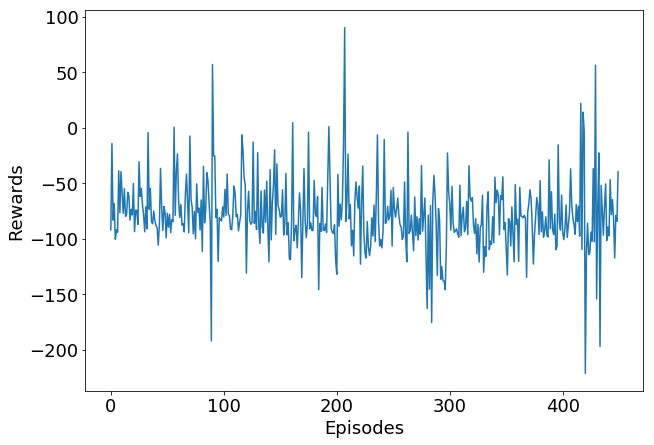

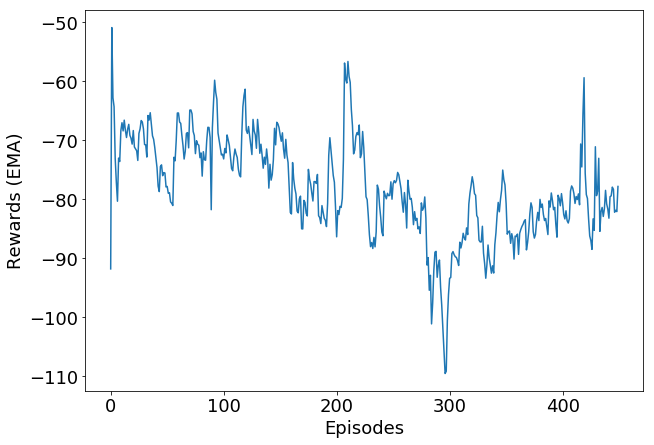

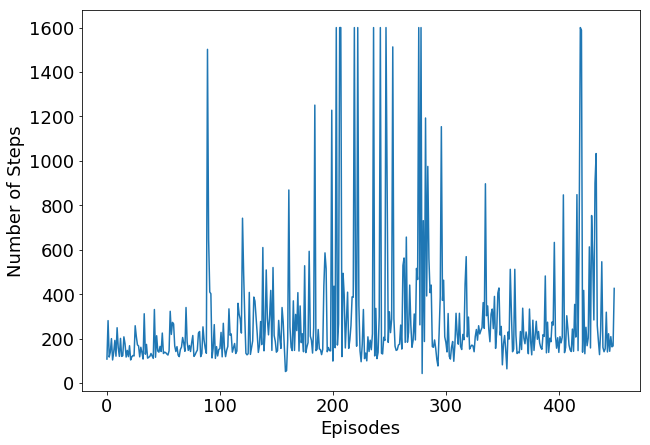

In [18]:
rewards_train['task2'] = []
eps = []

env2 = gym.make("BipedalWalker-v3", hardcore = True)
env2.reset(seed = 24)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = env2.reset()
    ep_reward = 0
    t = 0
    done = False
#     for t in range(max_steps):
    while not done:
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = env2.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer)
        
        state = next_state
        ep_reward += reward
        t += 1
        
        if done:
            break
    eps.append(t)

    rewards_train['task2'].append(ep_reward)

print('Training Complete')
rewards_env2 = rewards_train['task2']
plot_rewards(rewards_env2)
plot_smoothed(rewards_env2, 0.1)

plt.plot(range(len(eps)), eps)
plt.xlabel("Episodes")
plt.ylabel("Number of Steps")
plt.show()
plt.close()

## Task 1 (test)

env Complete


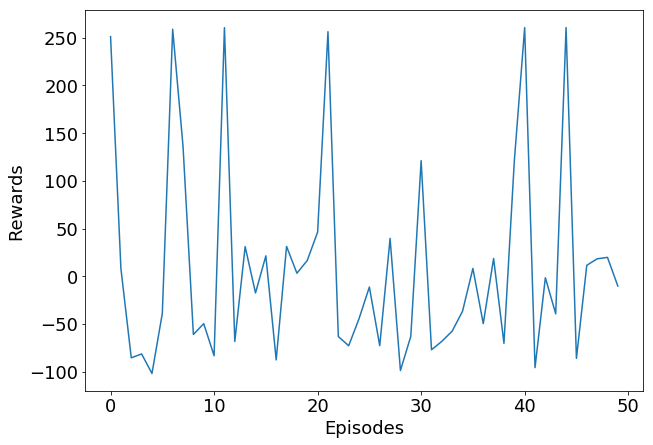

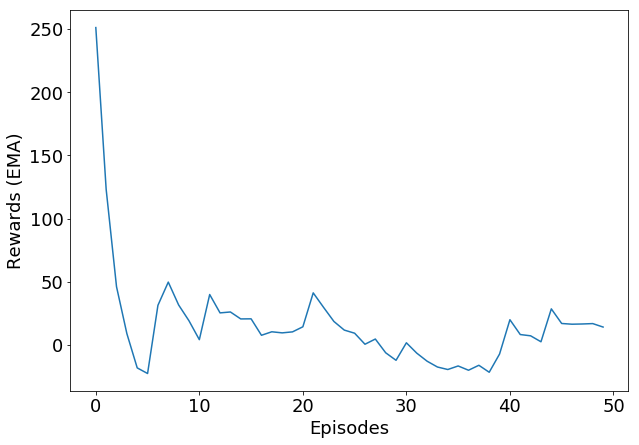

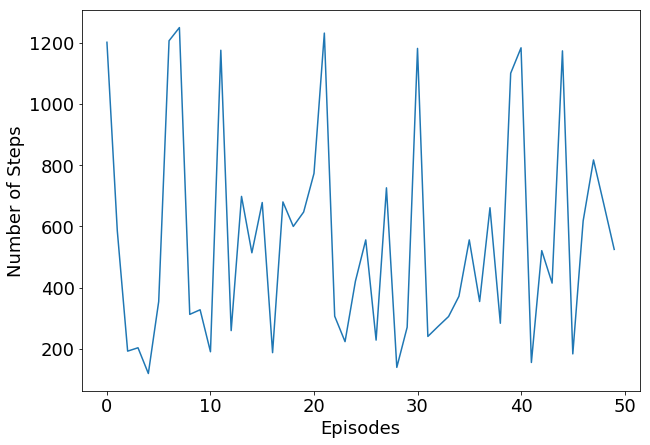

In [23]:
rewards_test['task1'] = []
eps_test = []
test_eps = 50

for ep in range(test_eps):
    state = env.reset()
    ep_reward = 0
    done = False
    t = 0
#     for t in range(max_steps):
    while not done:
        action = policy_net.get_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        ep_reward += reward
        t += 1
        
        if done:
            break
            
    eps_test.append(t)
    rewards_test['task1'].append(ep_reward)

print('env Complete')
rewards_env = rewards_test['task1']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

plt.plot(range(len(eps_test)), eps_test)
plt.xlabel("Episodes")
plt.ylabel("Number of Steps")
plt.show()
plt.close()

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


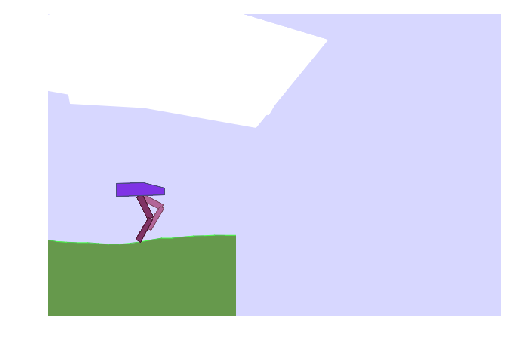

In [24]:
# Save video of env agent
frames = []
for i in range(1):
    state = env.reset()
    done = False
    while not done:
#     for t in range(max_steps):
        #Render to frames buffer
        frames.append(env.render(mode = 'rgb_array'))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = env.step(action)        
        state = next_state
        if done:
            break
env.close()
save_frames_as_gif(frames, filename='bipedal_walker_test_normal.gif')

## Task 2 (test)

env2 Complete


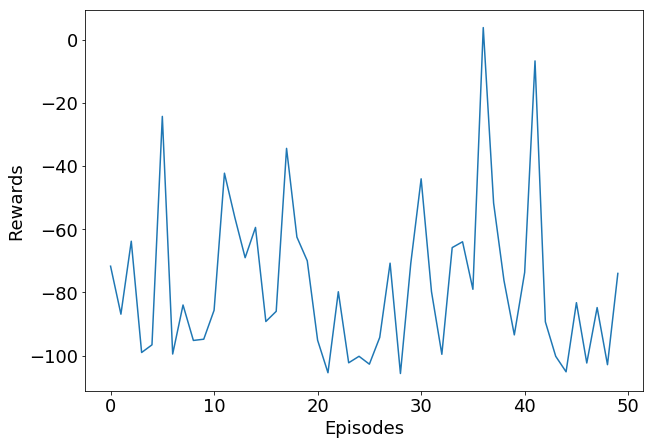

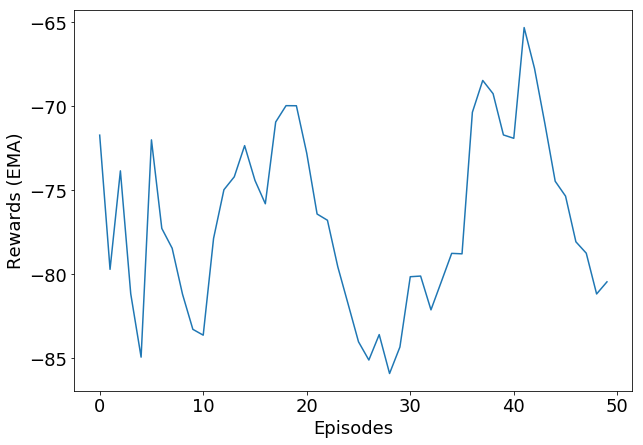

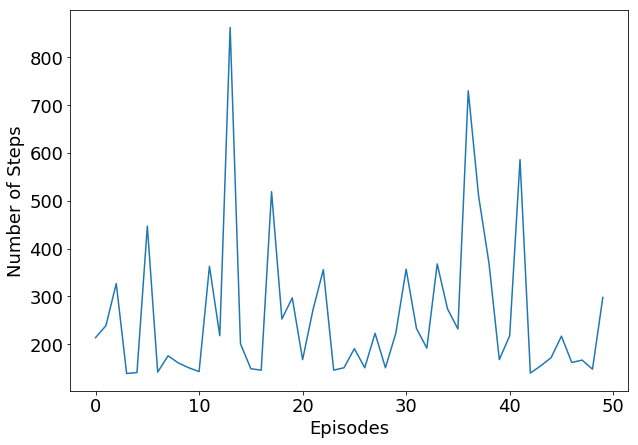

In [19]:
rewards_test['task2'] = []
eps_test = []
test_eps = 50

for ep in range(test_eps):
    state = env2.reset()
    ep_reward = 0
    done = False
    t = 0
#     for t in range(max_steps):
    while not done:
        action = policy_net.get_action(state)
        next_state, reward, done, _ = env2.step(action)
        state = next_state
        ep_reward += reward
        t += 1
        
        if done:
            break
            
    eps_test.append(t)
    rewards_test['task2'].append(ep_reward)

print('env2 Complete')
rewards_env2 = rewards_test['task2']
plot_rewards(rewards_env2)
plot_smoothed(rewards_env2, 0.1)

plt.plot(range(len(eps_test)), eps_test)
plt.xlabel("Episodes")
plt.ylabel("Number of Steps")
plt.show()
plt.close()

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


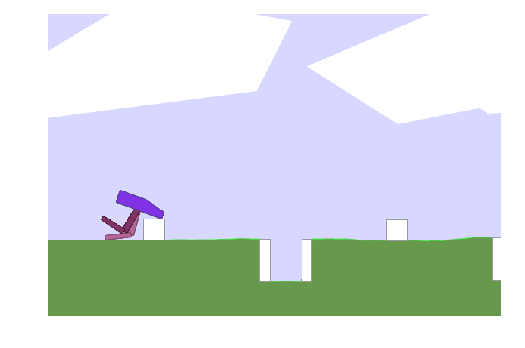

In [20]:
# Save video of env2 agent
frames = []
for i in range(1):
    state = env2.reset()
    done = False
    while not done:
#     for t in range(max_steps):
        #Render to frames buffer
        frames.append(env2.render(mode = 'rgb_array'))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = env2.step(action)        
        state = next_state
        if done:
            break
env2.close()
save_frames_as_gif(frames, filename='bipedal_walker_hardcore.gif')

### Test Results

In [25]:
test_df = pd.DataFrame(rewards_test)
train_df = pd.DataFrame(rewards_train)
# test_df.to_csv('./Data/test_rewards_bp_walker_logcosh.csv')

In [26]:
print("****TRAINING RESULTS****")
print(train_df.tail(50).mean())
print("****TEST RESULTS****")
print(test_df.mean())

****TRAINING RESULTS****
task1    86.046214
task2   -79.600218
dtype: float64
****TEST RESULTS****
task1    10.082162
task2   -77.406478
dtype: float64
